# Lung Vasculature Analysis
This notebook (.ipynb) is a working project for analyzing lung vasculature. It inculdes three parts:
1. converts skeleton analytical output (.xml) into .csv file.  
2. calulates the length and average thickness of each segment.
3. makes two types of plots: 
    1. histogram of each dataset on length and thickness
    2. average histogram on length and thickness (line plot with error bars)


In [62]:
%load_ext autoreload
%autoreload 2
import os, sys, re, io
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from core.fileop import DirCheck, ListFiles
import core.mkplot as mkplot 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 ## Part 1: 
 Converting skeleton analytical output (.xml) into .csv file.
 * Inputs: *.xml 
 * Outputs: *.csv
 * Dependencies: xml, time, pandas, tqdm </br>
 
 * *.xml file includes three sheets: nodes, points, and segments. 
 * Warning: the progress bar controled by `tqdm` is not functioning well. It can not overwrite itself and creates multiple lines. 

### Functions

In [63]:
# import dependencies
import xml.etree.ElementTree as etree
from core.msxml import MSXmlReader

# function
def convert_xml_csv(ippath, oppath):
    filelist, fileabslist = ListFiles(ippath, extension='.xml')
    
    for idx, f in enumerate(filelist):
        filename = f.replace('.xml', '')
        ip = os.path.join(ippath, f) 
        op = os.path.join(oppath, filename)
        
        print(ip)
        print(op)

        # create path
        if filename not in os.listdir(oppath):
            DirCheck(op)
            
            # convert *.xml to *.csv 
            csv_all = MSXmlReader(ip)
            
            # save each spreadsheet into individual *.csv file
            for key, value in csv_all.items():
                oppath_tmp = os.path.join(op, key + '.csv')
                value.to_csv(oppath_tmp, index = False)


### Execution
To run the code, please change `path` to the directory hosts the raw data. 

In [64]:
path = '/Users/major_minor1982/Documents/WUCCI/data/test'
ipdir = 'raw'
opdir = 'csv'
ippath = os.path.join(path, ipdir)
oppath = os.path.join(path, opdir)
# make dir
DirCheck(oppath)

# convert files in batch
convert_xml_csv(ippath, oppath)


/Users/major_minor1982/Documents/WUCCI/data/test/raw/16_FOR6-DCKO-Hypoxia.xml
/Users/major_minor1982/Documents/WUCCI/data/test/csv/16_FOR6-DCKO-Hypoxia
/Users/major_minor1982/Documents/WUCCI/data/test/raw/17_FOR7-DFF-Hypoxia.xml
/Users/major_minor1982/Documents/WUCCI/data/test/csv/17_FOR7-DFF-Hypoxia


 ## Part 2: 
 Calulating the length and average thickness of each segment.
 * Inputs: nodes.csv, points.csv, segments.csv
 * Outputs: segments_s.csv
 
 `SegStats` extracts euclidean coordinates and thickness of each point, then calculate the total length and average thickness. 

### Functions

In [65]:
# load dependencies
from core.filamentanalysis import SegStats

# function
def stats_calculator(ippath, oppath):
    imglist = [x for x in os.listdir(ippath) if not x.startswith('.')]
    
    var = ['df_nodes', 'df_points', 'df_segments']
    for img in imglist:
        filelist, fileabslist = ListFiles(os.path.join(ippath, img), extension='.csv')
        
        df_points = pd.read_csv(os.path.join(ippath, img, 'points.csv')) 
        df_segments = pd.read_csv(os.path.join(ippath, img, 'segments.csv')) 
        
        opfilename = 'segments_s.csv'
    
        if opfilename not in filelist:
            df_segments_s = SegStats(df_points, df_segments)            
            df_segments_s.to_csv(os.path.join(oppath, img, opfilename), index = False)
                

### Execution
To run the code, please change `path` to the directory hosts the raw data. 

In [66]:
path = '/Users/major_minor1982/Documents/WUCCI/data/test'
ipdir = 'csv'
opdir = 'csv'
ippath = os.path.join(path, ipdir)
oppath = os.path.join(path, opdir)
# make dir
DirCheck(oppath)

# convert files in batch
stats_calculator(ippath, oppath)

## Part 3: 
Creating two sets of plots: 
1. histogram of each dataset on length and thickness
2. average histogram on length and thickness (line plot with error bars)

 * Inputs: segments_s.csv
 * Outputs: 
     1. `histo/length/*.png`: frequency - length (µm)
     2. `histo/thickness/*.png`: frequency - thickness (µm)
     3. `histo_summary/length.png`: histogram in line plot style
     4. `histo_summary/thickness.png`: histogram in line plot style
 
 `SegStats` extracts euclidean coordinates and thickness of each point, then calculate the total length and average thickness. 

In [107]:
# import depandencies
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')
from core.mkplot import GroupImg, FindRange, IndividualHisto 

# functions
def make_individul_plots(ippath, oppath):
    # extract file list
    imglist = [x for x in os.listdir(ippath) if not x.startswith('.')]
    # get range
    length_range, thickness_range = FindRange(ippath)
    # print(length_range, thickness_range)
    
    # create labels
    xlabel = ['Length (µm)', 'Thickness (µm)'] 

    # make histogram for individual dataset
    for img in imglist:
        
        df_segments_s = pd.read_csv(os.path.join(ippath, img, 'segments_s.csv'))
        
        # histogram for average length  
        plt.figure(figsize=(5, 5))
        
        ax = IndividualHisto(df_segments_s, column = 'length', bin_range = length_range)
        ax.set_xlabel(xlabel[0])
        ax.set_ylabel('Frequency (%)')
                   
        DirCheck(os.path.join(oppath, 'histo', 'length'))
        opfilename = os.path.join(oppath, 'histo', 'length', img + '.png')
        plt.savefig(opfilename)
        plt.close()

        # histogram for average thickness    
        plt.figure(figsize=(5, 5))

        ax = IndividualHisto(df_segments_s, column = 'thickness', bin_range = thickness_range)
        ax.set_xlabel(xlabel[1])
        ax.set_ylabel('Frequency (%)')
        
        DirCheck(os.path.join(oppath, 'histo', 'thickness'))
        opfilename = os.path.join(oppath, 'histo', 'thickness', img + '.png')
        plt.savefig(opfilename)
        plt.close()   

    return    

def make_merged_plots(ippath, oppath):
    # extract file list
    imglist = [x for x in os.listdir(ippath) if not x.startswith('.')]
    # get range
    length_range, thickness_range = find_range(ippath)
    
    # create labels
    xlabel = ['Length (µm)', 'Thickness (µm)']
    
    # treatment
    grp_imglist = GroupImg(ippath, fileinfo)
    
    plt.figure(figsize=(5, 5))
    dflist = []
    for treatment, imgs in grp_imglist.items():
        binsize = 100
        
        bins = np.linspace(length_range[0], length_range[1], binsize) 
        
        for img in imgs:
            df_segments_s = pd.read_csv(os.path.join(ippath, img, 'segments_s.csv'))
            df_segments_s['bins'] = pd.cut(df_segments_s['length'], bins = bins)
            df_bins_count = df_segments_s.groupby('bins').size()
            df_bins_count = df_bins_count.reset_index()
            df_bins_count = df_bins_count.iloc[:, 1]
            dflist.append(df_bins_count)
        
        df_tmp = pd.concat(dflist, axis = 1)
        dfarray = np.array(df_tmp)
        mean = dfarray.mean(axis = 1, keepdims = True)
        #print(mean)
        sem = stats.sem(dfarray, axis = 1)
        #print(sem)
        ax1 = plt.subplot(111)
        bins_length = np.array([bins[0:-1]]).T
        # print(bins_length.shape)
        # print(mean.shape)
        ax1.errorbar(bins_length, mean, yerr = sem, alpha = 0.2)
        ax1.set_xlabel(xlabel[0])
        ax1.set_ylabel('Frequency (%)')
    
        opfilename = os.path.join(oppath, 'histo_summary', treatment + 'length.png')
        plt.savefig(opfilename)
        plt.show()
        plt.close()
    
    plt.figure(figsize=(5, 5))
    dflist = []
    for treatment, imgs in grp_imglist.items():
        binsize = 100
        
        bins = np.linspace(thickness_range[0], thickness_range[1], binsize) 
        
        for img in imgs:
            df_segments_s = pd.read_csv(os.path.join(ippath, img, 'segments_s.csv'))
            df_segments_s['bins'] = pd.cut(df_segments_s['thickness'], bins = bins)
            df_bins_count = df_segments_s.groupby('bins').size()
            df_bins_count = df_bins_count.reset_index()
            df_bins_count = df_bins_count.iloc[:, 1]
            dflist.append(df_bins_count)
        
        df_tmp = pd.concat(dflist, axis = 1)
        dfarray = np.array(df_tmp)
        mean = dfarray.mean(axis = 1, keepdims = True)
        #print(mean)
        sem = stats.sem(dfarray, axis = 1)
        #print(sem)
        ax1 = plt.subplot(111)
        bins_length = np.array([bins[0:-1]]).T
        # print(bins_length.shape)
        # print(mean.shape)
        ax1.errorbar(bins_length, mean, yerr = sem, alpha = 0.2)
        ax1.set_xlabel(xlabel[1])
        ax1.set_ylabel('Frequency (%)')
        
        opfilename = os.path.join(oppath, 'histo_summary', treatment + 'thickness.png')
        plt.savefig(opfilename)
        plt.show()
        plt.close()

    return

In [108]:
path = '/Users/major_minor1982/Documents/WUCCI/data/test'
ipdir = 'csv'
opdir1 = 'plot'
opdir2 = 'histogram'
subfolder = ['histo', 'histo_summary']
ippath = os.path.join(path, ipdir)
oppath = os.path.join(path, opdir1, opdir2)
for i in subfolder:
    oppath_sub = os.path.join(oppath, i)
    DirCheck(oppath_sub)

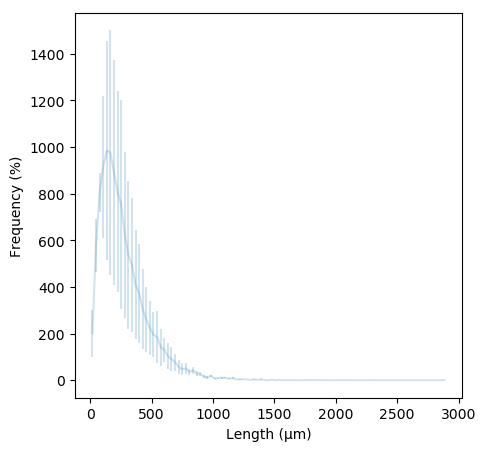

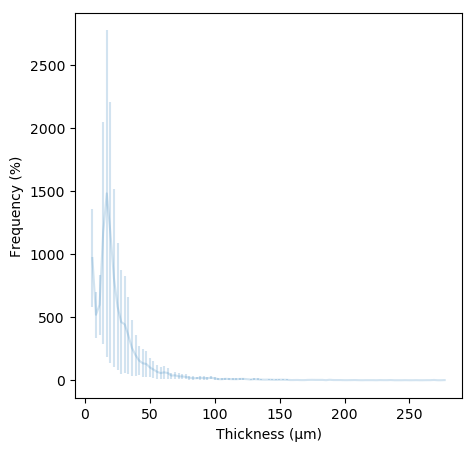

In [109]:
# load fileinfo
fileinfo = pd.read_csv(os.path.join(path, 'par', 'lung_file_idx.csv'))
# display(fileinfo)

make_individul_plots(ippath, oppath)
make_merged_plots(ippath, oppath)